### Importing the needed libraries

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/stage1_train/'
TEST_PATH = 'dataset/stage2_test_final/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

Using TensorFlow backend.
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

###  1. Preparing the data

In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [3]:
len(test_ids)

3019

In [ ]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


  9%|███████▏                                                                         | 59/670 [00:29<04:31,  2.25it/s]

###  2. Data Augmentation

In [ ]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [ ]:
# Checking if the images fit

from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [ ]:
#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

###  3. Creating the U-net model

In [ ]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [23]:
# Build U-Net model
from keras.applications import VGG16


vgg16  = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

ll = {'in': s}
last = 'in'
use = ['block2_conv2', '']
for layer in vgg16.layers:
    if layer.name != 'input_23':
        ll[layer.name] = vgg16.get_layer(layer.name)(ll[last])
        last = layer.name
        print(layer.name)


c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)#32

c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4, ll['block4_conv3']])
c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3,  ll['block3_conv3']])
c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2,  ll['block2_conv2']])
c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1, ll['block1_conv2']], axis=3)
c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

58892288/58889256 [==============================] - ETA:  - ETA: 7: - ETA: 6: - ETA: 4: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 47s - ETA: 46 - ETA: 33 - ETA: 34 - ETA: 29 - ETA: 30 - ETA: 26 - ETA: 27 - ETA: 24 - ETA: 25 - ETA: 23 - ETA: 23 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

###  4. Training

In [1]:
# Fit model
#earlystopper = EarlyStopping(patience=3, verbose=1)
#checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
#results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
#                              epochs=30, callbacks=[earlystopper, checkpointer])

###  5. Prediction

In [25]:
# Predict on train, val and test
model.load_weights('my_model.h5')
#model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

3019/3019 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 53 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 33 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 107s 35ms/step


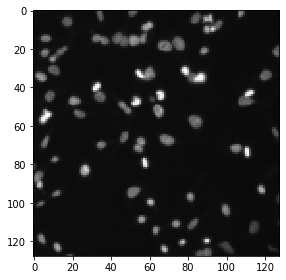

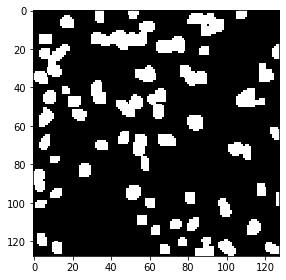

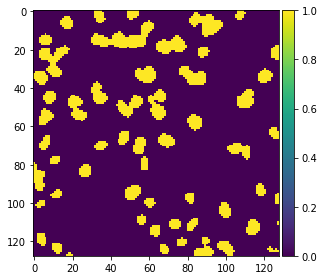

In [26]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

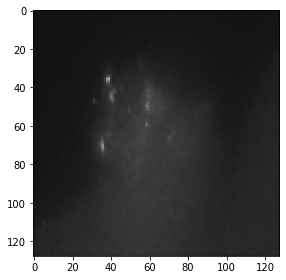

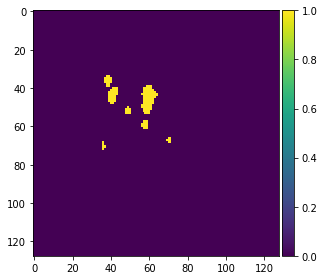

In [27]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_test_t))

imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [28]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [29]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [30]:
len(new_test_ids)

61747

In [31]:
len(rles)

61747

In [32]:
str_rles = []
for i in range (len(new_test_ids)):
    str_rles.append(' '.join(map(str, rles[i])) )

In [19]:
from pandas import DataFrame

Submission = {'ImageId': new_test_ids,
        'EncodedPixels': str_rles
        }

df = pd.DataFrame(data=Submission)
export_csv = df.to_csv (r'submission.csv', index = None, header=True)
df.head()

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,4362 6 4617 8 4872 10 5126 12 5381 13 5634 16 ...
1,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,14594 7 14849 10 15105 11 15361 11 15617 12 15...
2,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,41730 2 41985 5 42241 7 42497 8 42753 10 43009...
3,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,30220 4 30474 9 30728 12 30983 14 31239 15 314...
4,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,55839 4 56092 9 56346 12 56600 15 56855 17 571...


In [33]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission.csv', index=False)
sub.head()

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,4108 5 4362 8 4617 10 4870 13 5122 17 5377 18 ...
1,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,13826 6 14081 9 14337 10 14593 11 14849 12 151...
2,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,40962 2 41217 4 41473 5 41729 6 41985 7 42241 ...
3,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,30220 6 30474 10 30728 13 30983 15 31238 17 31...
4,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,56093 8 56346 13 56601 14 56855 17 57109 19 57...
